In [1]:
import numpy as np
import tifffile
import os
import pandas as pd
import glob
import random
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(5)

In [3]:
def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:1')
    else:
        device = torch.device('cpu')
        
    print(device)

    return device


device = set_device()

cuda:1


In [4]:
from torchvision import transforms

def train_transform(img):
    x = np.zeros(img.shape,dtype=np.float32)
    for i in range(img.shape[0]):
        if img[i].min() >= 0:
            img[i]/=255
        else:
            img[i] = (img[i] - img[i].min())/(img[i].max()-img[i].min())
        
        m = img[i].mean()
        s = img[i].std()
        x[i] = (img[i]-m)/s
    
    x = torch.tensor(x)
    transform = transforms.Compose([
#         transforms.ToPILImage(),
        transforms.RandomRotation([0,180]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip()
    ])
    x = transform(x)
    
    return x

class train_cycledataset():
    def __init__(self,filelist,transform):
        self.filelist = filelist
        self.transform = transform
        
    def __getitem__(self,index):
        if isinstance(self.filelist,list()):
            img = tifffile.imread(self.filelist[index])
            img = np.concatenate((img[0:2],np.expand_dims(img[4],axis=0)),axis=0)

            img = self.transform(img)
            if 'rfp' in self.filelist[index]:
                return [img.to(device), torch.tensor([1],dtype=torch.int,device=device)]
            else:
                return [img.to(device), torch.tensor([0],dtype=torch.int,device=device)]
        else:
            img = tifffile.imread(self.filelist.iloc[index,0])
            img = np.concatenate((img[0:2],np.expand_dims(img[4],axis=0)),axis=0)

            img = self.transform(img)
            if 'rfp' in self.filelist.iloc[index,0]:
                return [img.to(device), torch.tensor([1],dtype=torch.int8,device=device)]
            else:
                return [img.to(device), torch.tensor([0],dtype=torch.int8,device=device)]        

                        
    def getbatch(self,indices):
        images = torch.tensor([], device=device)
        labels = torch.tensor([], device=device)
        for index in indices:
            image, label = self.__getitem__(index)
            image = torch.unsqueeze(image,dim=0)
            images = torch.cat((images,image),dim=0)
            labels = torch.cat((labels,label))
        return images, labels
                        
    def __len__(self):
        if type(self.filelist) is list(): return len(self.filelis)
        else: return self.filelist.shape[0]


In [5]:
def test_transform(img):
    x = np.zeros(img.shape,dtype=np.float32)
    for i in range(img.shape[0]):
        if img[i].min() >= 0:
            img[i]/=255
        else:
            img[i] = (img[i] - img[i].min())/(img[i].max()-img[i].min())
        
        m = img[i].mean()
        s = img[i].std()
        x[i] = (img[i]-m)/s
    
    x = torch.tensor(x)

    return x

class test_cycledataset():
    def __init__(self,filelist,transform):
        self.filelist = filelist
        self.transform = transform
        
    def __getitem__(self,index):
        if type(self.filelist) is list():
            img = tifffile.imread(self.filelist[index])
            img = np.concatenate((img[0:2],np.expand_dims(img[4],axis=0)),axis=0)
            img = self.transform(img)
            if 'rfp' in self.filelist[index]:
                return [img.to(device), torch.tensor([1],dtype=torch.int,device=device)]
            else:
                return [img.to(device), torch.tensor([0],dtype=torch.int,device=device)]
        else:
            img = tifffile.imread(self.filelist.iloc[index,0])
            img = np.concatenate((img[0:2],np.expand_dims(img[4],axis=0)),axis=0)
            img = self.transform(img)
            if 'rfp' in self.filelist.iloc[index,0]:
                return [img.to(device), torch.tensor([1],dtype=torch.int8,device=device)]
            else:
                return [img.to(device), torch.tensor([0],dtype=torch.int8,device=device)]        

                        
    def __len__(self):
        if type(self.filelist) is list(): return len(self.filelis)
        else: return self.filelist.shape[0]
    

In [17]:
train = pd.read_csv('path to csv file of training set')
traindataset = train_cycledataset(train,train_transform)
val = pd.read_csv('path to csv file of validation set')
valdataset = test_cycledataset(val,test_transform)
test = pd.read_csv(''path to csv file of test set')
testdataset = test_cycledataset(test, test_transform)
print(f'number of training set:{len(traindataset)}')
print(f'number of validation set:{len(valdataset)}')
print(f'number of test set:{len(testdataset)}')

from torch.utils.data import DataLoader

bs = 64

trainloader = DataLoader(traindataset,batch_size=bs,shuffle=True)
valloader = DataLoader(valdataset,batch_size=bs,shuffle=True)
testdataloader = DataLoader(testdataset,batch_size=bs,shuffle=True)

number of training set:6345
number of validation set:2116
number of test set:2116


In [7]:
classifier = models.ResNet34(pretrained=True)

In [9]:
classifier.fc = torch.nn.Sequential(
    torch.nn.Linear(512,2,bias=True)
)

In [10]:
def accuracy(dl,model):
    n = 0
    acc = 0
    y_pred = torch.tensor([])
    label = torch.tensor([])
    model.eval()
    for x, y in dl:
        n += y.shape[0]
        x = x.to(device)
        y = y.to(device)
        yhat = model(x)
        p = torch.max(yhat,1)[1]  # return the index of maximum (max prob after sofmax)
        y_pred = torch.cat([y_pred,p.cpu()])
        label = torch.cat([label,y.view(-1).cpu()])
        correct = (y.view(-1) == p).sum().float()
        acc += correct
        
    f1score = f1_score(label,y_pred,average='micro')
    return [acc.item()/n*100, f1score]

In [11]:
save_dir = 'path to the folder to save trained model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [18]:
import time
from torch.optim.lr_scheduler import LambdaLR

epoch = 50
lr = 0.001
loss_fn = nn.CrossEntropyLoss()
classifier = classifier.to(device)
wd = 0
optimizer = optim.Adam(classifier.parameters(),lr=lr,weight_decay=wd)

lambda1 = lambda i: lr - lr/epoch*i
scheduler = LambdaLR(optimizer, lr_lambda=lambda1)


train_loss = []
train_acc = []
val_loss, val_acc, val_fscore = [], [], []

start = time.time()
for i in range(epoch):    
    acc = 0
    print('epoch:{:2d}'.format(i+1))
    classifier.train()
    l = 0.0
    m = 0
    for j, (x,y) in enumerate(trainloader):
        n = j
        m += y.shape[0]
        optimizer.zero_grad()
        yhat = classifier(x)
        loss = loss_fn(yhat,y.long().view(-1))
        l += loss.item()
        loss.backward()
        optimizer.step()
        p = torch.max(yhat,1)[1]    
        correct = (y.view(-1) == p).sum().float().item()
        acc += correct
    
    train_loss.append(l/(n+1))
    train_acc.append(acc/m*100)
    print("training loss={:.4f} training accuracy={:.2f}%".format(train_loss[i],train_acc[i]))
   
    l = 0.0
    classifier.eval()
    with torch.no_grad():
        for j, (x,y) in enumerate(valloader):
            n = j
            yhat = classifier(x)
            loss = loss_fn(yhat,y.long().view(-1))
            l += loss.item()
    
    val_loss.append(l/(n+1))
    if i == 0:
        torch.save(classifier.state_dict(),save_dir+'model.pth')
    else:
        if val_loss[i] < min(val_loss[0:i]):
            torch.save(classifier.state_dict(),save_dir+'model.pth')

    print('validation loss={:.4f}'.format(val_loss[i]))
    vacc, vf1 = accuracy(valloader,classifier)
    val_acc.append(vacc)
    print('validation acc={:.2f}%'.format(val_acc[i]))
    val_fscore.append(vf1)
    print('validation f1={:.2f}'.format(vf1))
    scheduler.step()

end = time.time()
training_time = end - start

epoch: 1
training loss=0.7507 training accuracy=47.47%
validation loss=0.6968
validation acc=53.69%
validation f1=0.54
epoch: 2
training loss=0.6885 training accuracy=56.25%
validation loss=0.6587
validation acc=60.26%
validation f1=0.60
epoch: 3
training loss=0.6580 training accuracy=60.76%
validation loss=0.6365
validation acc=63.80%
validation f1=0.64
epoch: 4
training loss=0.6301 training accuracy=64.29%
validation loss=0.6156
validation acc=66.12%
validation f1=0.66
epoch: 5
training loss=0.6148 training accuracy=66.35%
validation loss=0.5981
validation acc=68.24%
validation f1=0.68
epoch: 6
training loss=0.5888 training accuracy=68.87%
validation loss=0.5941
validation acc=69.75%
validation f1=0.70
epoch: 7
training loss=0.5727 training accuracy=70.24%
validation loss=0.5860
validation acc=70.46%
validation f1=0.70
epoch: 8
training loss=0.5719 training accuracy=70.91%
validation loss=0.5809
validation acc=71.03%
validation f1=0.71
epoch: 9
training loss=0.5650 training accuracy=

In [19]:
print('training time:{}'.format(training_time))

training time:1414.6099412441254


In [20]:
with open(save_dir+'set.txt','w') as file:
    file.write('batch size:{}\n'.format(bs))
    file.write('epoch:{}\n'.format(epoch))
    file.write('optimizer:{}\n'.format(optimizer))
    file.write('learning rate:{}\n'.format(lr))
    file.write('loss function:{}\n'.format(loss_fn))
    file.write('weight_decay:{}\n'.format(wd))
    file.write('lambda i: lr - lr/epoch*i\n')
    file.write('device:{}\n'.format('gtx 2080ti'))
    file.write('total training time:{}\n'.format(training_time))

df_34 = pd.DataFrame({'train_loss':train_loss,'train_acc':train_acc,'val_loss':val_loss,'val_acc':val_acc,'val_fscore':val_fscore})
df_34.to_csv(save_dir + 'loss.csv',index=False)

In [21]:
for i, (x,y) in enumerate(testdataloader):
    l = 0.0
    with torch.no_grad():
        n = i
        yhat = classifier(x)
        loss = loss_fn(yhat,y.long().view(-1))
        l += loss.item()

testloss = l/(1+n)
test_acc,test_f1score = accuracy(testdataloader,classifier)

print('test loss:{:.4f}'.format(testloss))
print('test acc:{:.2f}'.format(test_acc))
print('test f1 score:{:.2f}'.format(test_f1score))

with open(save_dir+'test.txt','w') as file:
    file.write('test loss:{}\n'.format(testloss))
    file.write('test acc:{:.2f}%\n'.format(test_acc))
    file.write('test f1 score:{:.2f}'.format(test_f1score))

test loss:0.0152
test acc:75.71
test f1 score:0.76


In [22]:
classifier.load_state_dict(torch.load(save_dir+'model.pth',map_location=device))
classifier.to(device)
classifier.eval()
loss_fn = nn.CrossEntropyLoss()

y_pred = torch.tensor([])
label = torch.tensor([])
n = 0
for i, (x,y) in enumerate(testdataloader):
    l = 0.0
    with torch.no_grad():
        n = i
        yhat = classifier(x)
        p = torch.max(yhat,1)[1]  # return the index of maximum (max prob after sofmax)
        y_pred = torch.cat([y_pred,p.cpu()])
        label = torch.cat([label,y.view(-1).cpu()])
        loss = loss_fn(yhat,y.long().view(-1))
        l += loss.item()



test_acc,test_f1score = accuracy(testdataloader,classifier)

testloss = l/(1+n)


print('test loss:{:.4f}'.format(testloss))
print('test acc:{:.2f}'.format(test_acc))
print('test f1 score:{:.2f}'.format(test_f1score))

with open(save_dir+'test2.txt','w') as file:
    file.write('test loss:{}\n'.format(testloss))
    file.write('test acc:{:.2f}%\n'.format(test_acc))
    file.write('test f1 score:{:.2f}'.format(test_f1score))


test loss:0.0138
test acc:75.33
test f1 score:0.75


In [23]:
import matplotlib.pyplot as plt

def plot_train(train_loss,train_acc,val_loss,val_acc,epoch,model_name:str):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title('Loss',fontsize=15)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(train_loss,label='Train')
    plt.plot(val_loss,label='Validation')
    plt.legend()
    plt.subplot(1,2,2)
    plt.title('Accuracy',fontsize=15)
    plt.xlabel('epoch')
    plt.ylabel('accuracy(%)')
    plt.plot(train_acc,label='Train')
    plt.plot(val_acc,label='Validation')
    plt.legend()
    plt.savefig(model_name+'loss_acc.png')

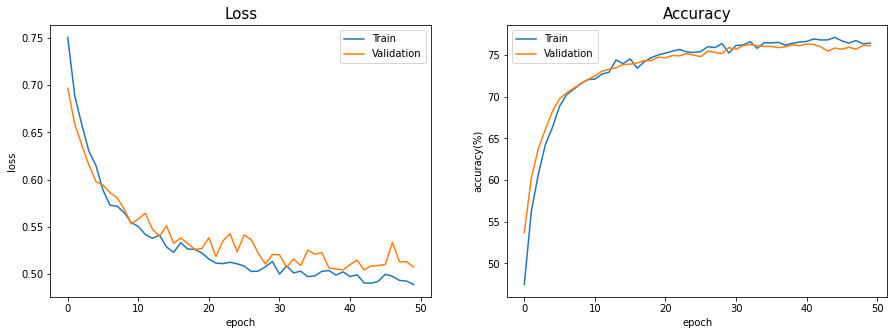

In [24]:
plot_train(train_loss,train_acc,val_loss,val_acc,epoch,save_dir)

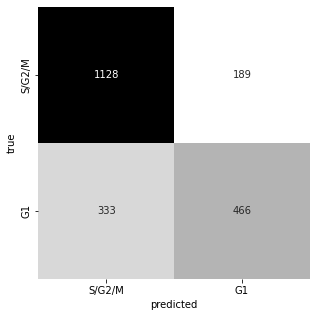

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

mat = confusion_matrix(label,y_pred)
plt.figure(figsize = (5,5))
sns.heatmap(mat,cmap='binary', square= True, annot=True, fmt='d', xticklabels=['S/G2/M','G1'], yticklabels=['S/G2/M','G1'], cbar= False)
plt.xlabel("predicted")
plt.ylabel("true")
plt.savefig(save_dir+'confusion_matrix.png')
plt.show()